Gabriel Silvestre Mancini

Pedro Di Celio Moraes

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
import seaborn as sns
from google.colab import files, drive
import os
import pickle as pk

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
def tirar_foto(quality=0.8, texto_botao="Capturar"):
  js = Javascript('''
    async function takePhoto(qual, texto) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = texto;
      div.appendChild(capture);

      // Abre a câmera
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      // Mostra a saída da câmera
      const video = document.createElement('video');
      video.style.display = 'block';
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', qual);
    }
    ''')
  display(js)
  return eval_js('takePhoto({}, "{}")'.format(quality, texto_botao))

In [6]:
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

In [7]:
def crop_rate(img, x,y,largura,altura, largura_lfw = 94, altura_lfw = 125, interpolation=cv2.INTER_AREA): #cv2.INTER_AREA
      razao_aspecto = altura_lfw/largura_lfw
      centro_x = x + largura/2
      centro_y = y + altura/2
      area = largura*altura
      largura_adj = np.sqrt(area/razao_aspecto)
      altura_adj = razao_aspecto*largura_adj
      x_min = int(np.floor(centro_x-largura_adj/2))
      x_max = int(np.ceil(centro_x+largura_adj/2))
      y_min = int(np.floor(centro_y-altura_adj/2 + 0.5))
      y_max = int(np.ceil(centro_y+altura_adj/2 + 0.5))
      if y_min <0:
         y_max -= y_min
         y_min = 0
      if x_min <0:
         x_max -= x_min
         x_min = 0
      # Centralize and crop
      crop_img = img[y_min:y_max, x_min:x_max]
      img_lfw = cv2.resize(crop_img, (largura_lfw, altura_lfw), interpolation=interpolation)

      print(img_lfw.shape)
      return img_lfw

## Leitura e tratamento das imagens

In [12]:
basedir = '/content/gdrive/MyDrive/FotosPosIA/'
turma_target_names = os.listdir(basedir)
n_classes = len(turma_target_names)

altura = 125
largura = 94

print(f'Nosso problema terá {n_classes} classes.')

for name in turma_target_names:
  print(name)

Nosso problema terá 45 classes.
Higor Freire da Fonseca
Gláucio Soares da Silva
Joao Paulo Mota
Guilherme Sousa
Guilherme Vick
Hiero de Paula
Gustavo Gomes
Isaac Barella
Gustavo G Rigor
Icaro Figaro
Macmore Maziero
Matias Herklotz
Lina Yoshida
Natalia Godoy
Pedro Nunes Guth
Jorge Filho
Pedro Moraes
Leonardo Tumonis
José Patino
Luiz Claudio Dias Mendes
Simone Brito
Rodrigo Florencio
Vitor Ozols
Sergio H Teixeira
Thais dos Santos Lino
Anderson Schinaid
Ricardo Sahara
Wallace Galvao
Rafael Costa Mendes
Cassio Serrano
Elido Gonzalez
Andre Teixeira
Deborah Godoi
Clarissa Mattos
Cristtiane Moreira
Carlos Curioni
Eduardo Matos
Emily Costa
Eduardo Marques
Felipe Amorim
Fernando Tamayose
Gabriel Torrezan
Flavio Vicentini
Gabriel Mancini
Gabriel Agune


In [13]:
altura_ofw = altura
largura_ofw = largura
turma_data = []
turma_target = []
for i in range(len(turma_target_names)):
  included_extensions = ['jpg','jpeg']
  imagens = [fn for fn in os.listdir(basedir+turma_target_names[i]+'/')
              if any(fn.endswith(ext) for ext in included_extensions)]
  for j in range(len(imagens)):
    img = cv2.imread('{0}/{1}/{2}'.format(basedir,turma_target_names[i],imagens[j]), cv2.IMREAD_GRAYSCALE)
    turma_data.append(img.reshape(1,-1)[0])
    turma_target.append(i)

In [16]:
turma_data = np.array(turma_data)
turma_target = np.array(turma_target)

print(turma_data.shape)
print(turma_target.shape)
print(len(turma_target_names))

(445, 11750)
(445,)
45


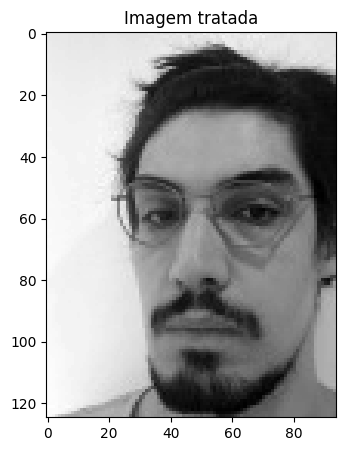

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(turma_data[425].reshape(altura, largura), cmap='gray')
plt.title('Imagem tratada')
plt.show()

In [22]:
# Verifique se o diretório existe, se não, crie-o
file_path = '/content/gdrive/MyDrive/AprendizadoMaquinasI/2024/ThisIsMe/Dataset/'
dir_path = os.path.dirname(file_path)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Salve os arquivos
with open(file_path+'turma_data.pkl', 'wb') as pickle_file:
    pk.dump(turma_data, pickle_file)

with open(file_path+'turma_target.pkl', 'wb') as pickle_file:
    pk.dump(turma_target, pickle_file)

with open(file_path+'turma_target_names.pkl', 'wb') as pickle_file:
    pk.dump(turma_target_names, pickle_file)

In [23]:
haar_face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [24]:
with open(file_path+'turma_data.pkl', 'rb') as arquivo:
    # Carregar o objeto do arquivo pickle
    turma_data = pk.load(arquivo)

with open(file_path+'turma_target.pkl', 'rb') as arquivo:
    # Carregar o objeto do arquivo pickle
    turma_target = pk.load(arquivo)

with open(file_path+'turma_target_names.pkl', 'rb') as arquivo:
    # Carregar o objeto do arquivo pickle
    turma_target_names = pk.load(arquivo)

turma_images = turma_data.reshape(len(turma_data), altura, largura)

In [25]:
len(turma_target_names)

45

In [26]:
len(turma_data)

445

# Análise e execução do PCA

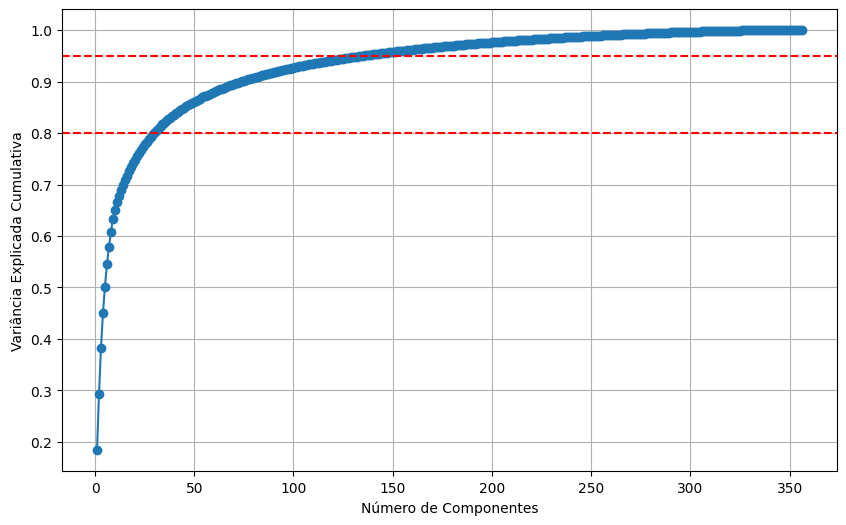

Quantidade de PCs que explicam 80% da variância: 29
Quantidade de PCs que explicam 95% da variância: 134


In [27]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(turma_data, turma_target, test_size=0.2, random_state=42)
n_components = len(X_train)

#achando o numero de componentes
nComponentes = PCA(n_components=n_components,svd_solver='randomized', whiten=True)
nComponentes.fit(X_train)
cumsum=np.cumsum(nComponentes.explained_variance_ratio_)

cumulative_variance_explained = np.cumsum(nComponentes.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance_explained, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variância Explicada')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variância Explicada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.grid(True)
plt.show()

qtd_pcs_80 = len(cumulative_variance_explained[cumulative_variance_explained <= 0.8])
qtd_pcs_95 = len(cumulative_variance_explained[cumulative_variance_explained <= 0.95])

print(f'Quantidade de PCs que explicam 80% da variância: {qtd_pcs_80}')
print(f'Quantidade de PCs que explicam 95% da variância: {qtd_pcs_95}')


# Aplicar PCA
pca = PCA(n_components=qtd_pcs_95,svd_solver='randomized', whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Treino e teste do modelo

In [28]:
# Treinar o modelo SVM
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

#validacao cruzada
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Melhor estimador encontrado pelo grid search:")
print(clf.best_estimator_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Melhor estimador encontrado pelo grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


<Figure size 1200x1200 with 0 Axes>

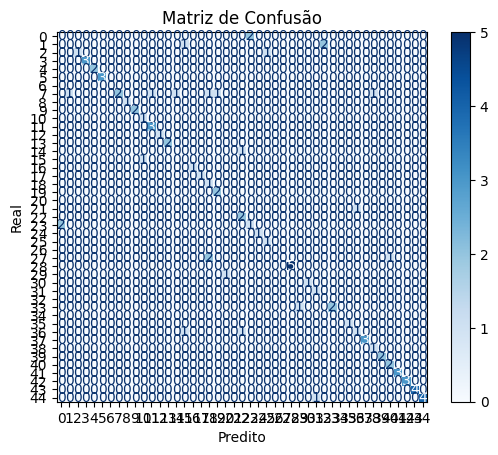

In [29]:
# Fazer previsões nos dados de teste
y_pred = clf.predict(X_test_pca)

# Avaliar o modelo
#print(classification_report(y_test, y_pred, target_names=turma_target_names))
#print(confusion_matrix(y_test, y_pred, labels=range(len(turma_target_names))))
cm=confusion_matrix(y_test, y_pred, labels=range(len(turma_target_names)))
# Mostrar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(turma_target_names)))
plt.figure(figsize=(12, 12))
disp.plot(cmap=plt.cm.Blues, values_format='.4g')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [32]:
# Calcular as métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Exibir as métricas
print(f'Acurácia: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Acurácia: 0.72
Recall: 0.71
F1 Score: 0.66


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


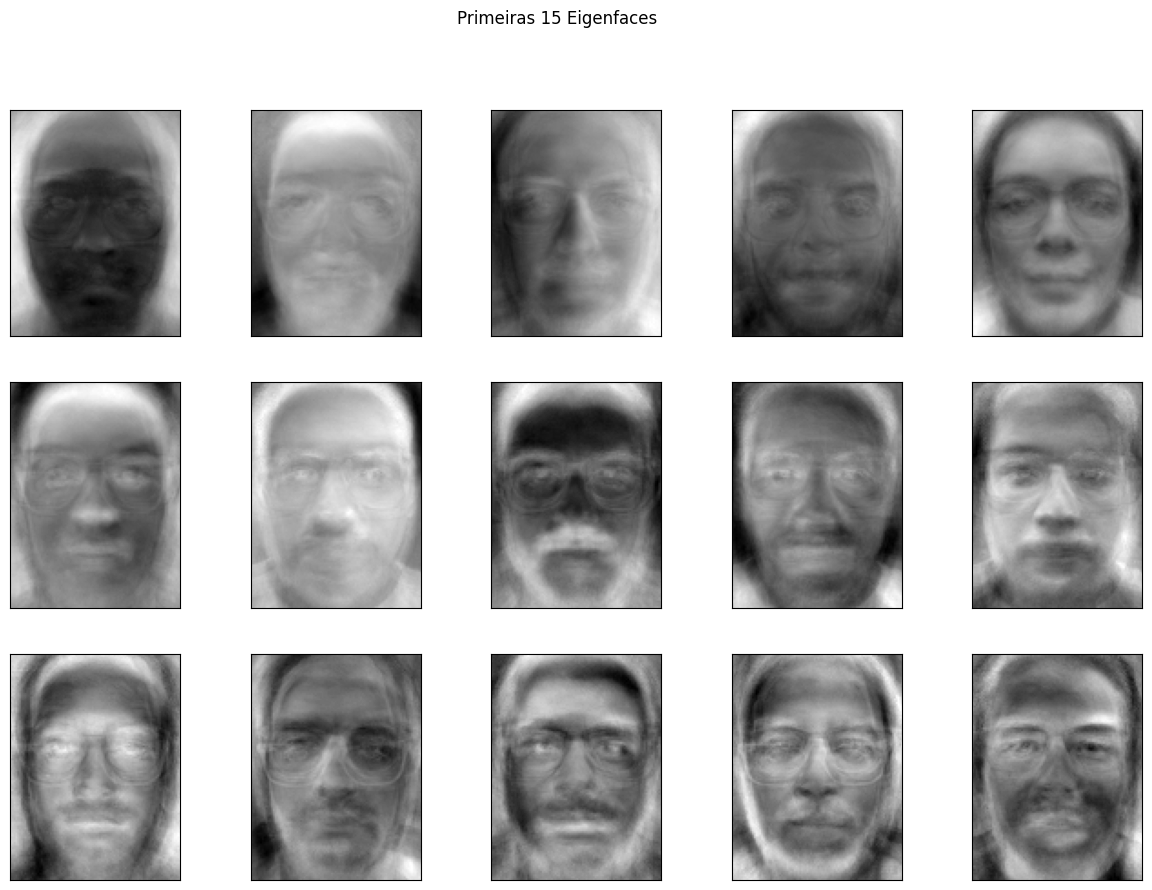

In [31]:
# Plotar as primeiras eigenfaces
eigenfaces = pca.components_.reshape((qtd_pcs_95, altura, largura))

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Primeiras 15 Eigenfaces")
plt.show()

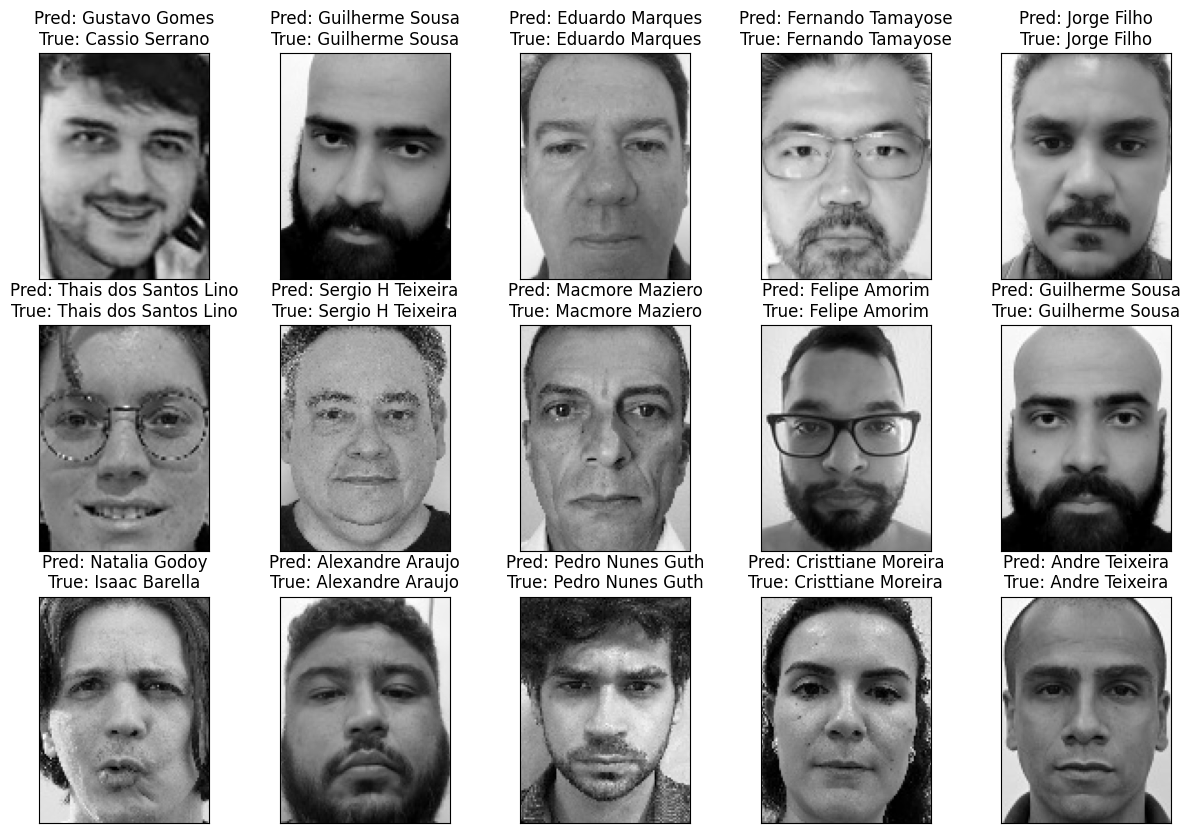

In [ ]:
# Plotar algumas imagens de teste com as previsões
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(altura, largura), cmap='gray')
    ax.set_title(f"Pred: {turma_target_names[y_pred[i]]}\nTrue: {turma_target_names[y_test[i]]}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
file_path = '/content/gdrive/MyDrive/AprendizadoMaquinasI/2024/ThisIsMe/'

with open(file_path+'clf.pkl', 'wb') as pickle_file:
    pk.dump(clf, pickle_file)

with open(file_path+'pca.pkl', 'wb') as pickle_file:
    pk.dump(pca, pickle_file)

<IPython.core.display.Javascript object>

(125, 94)


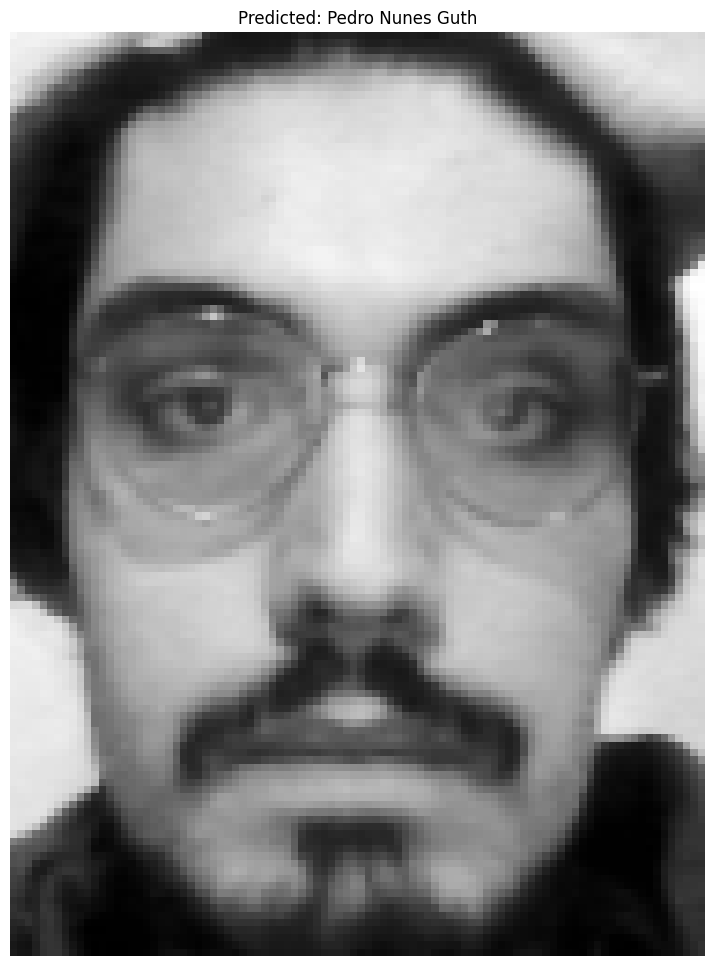

In [ ]:
try:
  imagem_urlb64 = tirar_foto()
  imbytes = b64decode(imagem_urlb64.split(',')[1])
  im = cv2.imdecode(np.frombuffer(imbytes, dtype=np.uint8), flags=1)
  # plt.imshow(im, cmap='gray'),plt.title('Imagem capturada')
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
# Reconhecimento de faces

rostos = haar_face_cascade.detectMultiScale(im)

# print(f'{rostos.shape[0]} rosto(s) detectado(s)')
n_rostos = rostos.shape[0]

# print(f'\n A matriz rostos:\n {rostos}')
# Colocando o retângulo ao redor da face reconhecida
for (x, y, largura, altura) in rostos:
  im_r = cv2.rectangle(im,(x,y),(x+largura,y+altura),(255,0,0),2)
#Plotando a imagem
# plt.imshow(im_r, cmap='gray'),plt.title('Rosto(s) Detectado(s)')
# Zoom no rosto detectado

plt.figure(figsize=(12,12)) # specifying the overall grid size
i=0
for (x, y, largura, altura) in rostos:
  i += 1
  # plt.subplot(1,n_rostos,i)    # the number of images in the grid is 5*5 (25)
  # plt.imshow(cv2.cvtColor(im[y:y+altura, x:x+largura], cv2.COLOR_BGR2RGB))
  # plt.title('image '+ str(i)+'largura: '+str(largura)+'x altura:'+str(altura))
# plt.show()
#se houver vários rostos, escolha o quadro desenhado ao redor da maior imagem,
x, y, largura, altura = rostos[rostos[:,-1].argsort()[-1]] #
# print(x,y,largura,altura)
# plt.imshow(gray[y:y+altura, x:x+largura], cmap='gray'),plt.title('Rosto Escolhido')
Pessoa = crop_rate(gray,x=x,y=y,largura=largura,altura=altura)
# plt.imshow(Pessoa, cmap='gray'),plt.title('Imagem para ser reconhecida')

# Aplicar PCA à imagem capturada
pca_image = pca.transform(Pessoa.reshape(1,-1))

# Fazer a previsão usando o modelo SVM treinado
prediction = clf.predict(pca_image)

# Obter o nome correspondente ao ID previsto
predicted_name = turma_target_names[prediction[0]]

# Mostrar a imagem capturada e o nome previsto
plt.imshow(Pessoa, cmap='gray')
plt.title(f'Predicted: {predicted_name}')
plt.axis('off')
plt.show()